# Preprocessing

In [31]:
# Link below contains information about building an environment from a .YML file
# Make sure to activate the environment before opening the notebook
# https://shandou.medium.com/export-and-create-conda-environment-with-yml-5de619fe5a2

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [33]:
import os

def readFile(wd, filename):
    try:    
        path = os.path.join(wd, "data", filename)
        file = pd.read_csv(path)
    except FileNotFoundError:
        print("Could not read file - Please check filepath")
        raise
    return file

wd = os.getcwd()
train = pd.read_csv("training_data.csv")
test = pd.read_csv("eval_data.csv")

## Pre-processing

pre-process the sessions (you can execute these tasks in the order you prefer, but make sure to specify which task is being solved in which block of code):
1. sessionise <font color='red'>(1pt)</font>
1. select sessions with at least one add-to-cart <font color='red'>(1pt)</font>
1. add class labels: treat purchase as the positive class <font color='red'>(1pt)</font>
1. cut purchase sessions to the last event before the first purchase <font color='red'>(1pt)</font>
1. remove sessions shorter than 5 and longer than 155 clicks <font color='red'>(1pt)</font>
1. symbolise actions <font color='red'>(1pt)</font>


In [34]:
# Sessionise:
# derive sessions from action by action dataset
# merge all the actions by session_id

def sessionize(df):
    df['product_action'] = df['product_action'].fillna('view')
    df = df.groupby('session_id_hash')['product_action'].agg(list).reset_index()
    return df

train = sessionize(train)
test = sessionize(test)

In [35]:
##  Label purchase sessions

def labelSet(df):
    df['purchase'] = np.where(df.product_action.map(set(['purchase']).issubset), 1, 0)
    return df

train = labelSet(train)
test = labelSet(test)

In [36]:
### Cut actions before purchase if there is one
### keep the full sesssion if there is not

def sliceSessions(df):
    df['product_action'] = df['product_action'].map(lambda x: x[0:x.index('purchase')] if 'purchase' in x else x)

    ## select sessions with at least one add-to-cart
    df = df[df.product_action.map(lambda x: "add" in x)]

    ### Filtered out outliers which > 155 or < 5.    

    df["len"] = df["product_action"].map(len)

    # removing very short and very long sessions
    df.drop(df[df.len < 5].index, inplace=True)
    df.drop(df[df.len > 155].index, inplace=True)
    
    return df

train = sliceSessions(train)
test = sliceSessions(test)

In [37]:
## Sanity check: the output should be True
def checkFaultySessions(df):
    print(df[df.product_action.map(lambda x: "add" not in x)].shape[0])
    
checkFaultySessions(train)
checkFaultySessions(test)

0
0


In [38]:
## symbolise actions, based on practical session 1
from collections import Counter
def symbolize(df, symbol2idx=None):
    sessions = df['product_action'].to_list()
    labels = df['purchase'].to_list()
    
    if symbol2idx == None:
        counts = Counter([item for session in sessions for item in session])
        symbol2idx = {symbol: idx for idx, symbol in enumerate(sorted(counts, key=counts.get, reverse=True), 1)}
        print("Symbol alphabet: ", symbol2idx)

    df["session"]=df["product_action"].map(lambda session: [symbol2idx[s] for s in session])
    
    return df, symbol2idx

train, symbol2idx = symbolize(train)
test, _ = symbolize(test, symbol2idx)
test.head()

Symbol alphabet:  {'view': 1, 'detail': 2, 'add': 3, 'remove': 4}


,session_id_hash,product_action,purchase,len,session
1,000010504025397b03290c7457e0e7ef7ae93529f21eae...,"[detail, view, detail, view, detail, view, vie...",0,81,"[2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, ..."
35,0002cc06d46d4835503b88e9eed2c8fc1ae97f5cc262a9...,"[view, detail, detail, view, add, view, view, ...",0,18,"[1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ..."
40,00030ffeaf340fe2ef44c91bca1a7cffd5f07d1a44a081...,"[view, detail, add, view, remove, add, remove,...",0,28,"[1, 2, 3, 1, 4, 3, 4, 1, 1, 1, 2, 1, 2, 1, 2, ..."
58,0004be10f232d2ebd86be1c1c46dcf741ee77651bc550d...,"[view, view, view, view, view, view, view, det...",0,15,"[1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 3, 1]"
74,0005ea00d00f64fbfaaa8b110f268025ba8ad963d8fdd3...,"[view, view, view, view, view, view, detail, v...",0,50,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, ..."


In [39]:
## Check the symbolisation
symbol2idx

{'view': 1, 'detail': 2, 'add': 3, 'remove': 4}

## Oracle model

In [40]:
from sklearn import metrics

def oracle(X_train, y_train):
    '''
    This function return a oracle model based on the session and label.
    '''
    from collections import defaultdict

    d = defaultdict(lambda: defaultdict(int))
    for s, l in zip(X_train, y_train):
        d[str(tuple(s))][l] += 1
        
    model = {}
    for session in d.keys():
        n_buy, n_ws = 0, 0
        for label in d[session].keys():
            if label:
                n_buy += d[session][label]
            else:
                n_ws += d[session][label]
        model[session] = n_buy / (n_buy + n_ws)
        
    return model

def oracle_predict(model, X_test, y_test=None):
    '''
    1. Make prediction on X_test.
    2. For possibility >0.5 predict 1, else 0.
    3. return prediction and F1 score
    '''

    y_pred = []
    for x in X_test:
        pos = model.get(str(x), "#") ## For sessions that not in the model, we assign it to #, and then predict 0.
        y_pred.append(pos)
        
    ## count "#" first and substitute with 0
    missing_rate = y_pred.count("#")/len(y_pred)

    y_pred = [1 if y != "#" and y >= 0.5 else 0 for y in y_pred]
        
    if y_test is not None:
#         y_test = y_test.to_list()
        f1 = metrics.f1_score(y_test, y_pred)
        return(f1, missing_rate,y_pred)
    else:
        return y_pred

In [41]:
## Oracle model for 5 clicks
## Subset from the original test
i = 5
data = test[["session", "purchase"]]
data.session = test.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = test.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

0.8706342991386061

In [42]:
# oracle model for 10 clicks
i = 10
data = test[["session", "purchase"]]
data.session = test.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = test.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

0.8706342991386061

In [43]:
# oracle model for 15 clicks
i = 15
data = test[["session", "purchase"]]
data.session = test.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = test.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

0.8706342991386061

## Subset by post-add-to-cart

1. Subset data for n-click (n=5, 10, 15) models.

In [44]:
## Get dataframe subsets
## make the prediction for 5, 10 and 15, and store the f1 it in a dict
from collections import defaultdict

def makeSubset(df):
    data = defaultdict(lambda: defaultdict())
    
    for i in [5, 10, 15]:    
        ## Subset from the original df
        temp = df[["session", "purchase"]]
        temp.session = temp.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
        temp = temp.dropna()
        
        data[f"{i}_clicks"]["X"] = temp.session.to_numpy()
        data[f"{i}_clicks"]["Y"] = temp.purchase.to_numpy()
    
    return data

train_data = makeSubset(train)
test_data = makeSubset(test)

In [45]:
train_size = pd.DataFrame(train_data).applymap(len)
test_size = pd.DataFrame(test_data).applymap(len)
print(train_size)
print(test_size)

   5_clicks  10_clicks  15_clicks
X    107767      75887      55270
Y    107767      75887      55270
   5_clicks  10_clicks  15_clicks
X     24969      17424      12704
Y     24969      17424      12704


## Naive Bayes Model

In [46]:
## Encode ngrams, code from practical session 2
def ngram_featurizer(session, n=3):
    
    """takes in a list and an integer defining the size of ngrams.
     Returns the ngrams of desired size in the input string"""
    
    session = ['#']*(n-1) + session + ['+']*(n-1)
    ngrams = [tuple(session[i:i+n]) for i in range(len(session)-n+1)]
    
    return ngrams
    

def encode_sessions(sessions,n=3, mapping=None):
    
    """
    Takes in a list of lists, an integer indicating the character ngrams' size,
    and a dictionary mapping ngrams to numerical indices. If no dictionary is passed,
    one is created inside the function.
    The function outputs a 2d NumPy array with as many rows as there are strings in 
    the input list, and the mapping from ngrams to indices, representing the columns 
    of the NumPy array.
    """
    
    if not mapping:
        all_ngrams = set()
        for session in sessions:
            all_ngrams = all_ngrams.union(set(ngram_featurizer(session, n)))
    
        mapping = {ngram: i for i, ngram in enumerate(all_ngrams)}
    
    X = np.zeros((len(sessions), len(mapping)))
    for i, session in enumerate(sessions):
        for ngram in ngram_featurizer(session, n):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    
    return X, mapping

In [47]:
from sklearn.naive_bayes import MultinomialNB

score = {}
for i in [5,10,15]:
    sessions_train = train_data[f"{i}_clicks"]["X"]
    labels_train = train_data[f"{i}_clicks"]["Y"]
    
    sessions_test = test_data[f"{i}_clicks"]["X"]
    labels_test = test_data[f"{i}_clicks"]["Y"]

    Xtrain, mapping = encode_sessions(sessions_train)
    Xtest, _ = encode_sessions(sessions_test, mapping=mapping)

    NB = MultinomialNB(alpha=1, fit_prior=True)
    NB.fit(Xtrain,labels_train)
    bayes_predictions = NB.predict(Xtest)
    
    f1 = metrics.f1_score(labels_test, bayes_predictions)
    
    score[f"F1_{i}-clicks"] = f1

In [48]:
print(score)

{'F1_5-clicks': 0.3124876701519037, 'F1_10-clicks': 0.356648541769649, 'F1_15-clicks': 0.3699518032241981}


## Advanced Model: XGBoost Classifier

In [53]:
##################################5 CLICKS  XGBOOST MODEL ################################
### Get the copy of the data
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
def xgboost_model(n_click = '5_clicks', downsample = True):
    
    X_train = train_data[n_click]['X']
    y_train = train_data[n_click]['Y']
    X_test = test_data[n_click]['X']
    y_test = test_data[n_click]['Y']
    
    if downsample == True:  ##### If downsample is set to True, this part will run and resample the data
        ### Downsampling the training data
        ### And keep the test data in shape
        temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

        class_0 = temp[temp.purchase == 0]
        class_1 = temp[temp.purchase == 1]

        class_0 = resample(class_0,
                     replace=True,
                     n_samples=len(class_1),
                     random_state=123)


        data_downsampled = pd.concat([class_0, class_1])

        X_train = data_downsampled.session
        y_train = data_downsampled.purchase
    ### Featurization
    ## Doing ngrams with n = 1 AND 2

    one_gram, mapping_1 = encode_sessions(X_train,n=1, mapping=None)
    two_gram, mapping_2 = encode_sessions(X_train,n=2, mapping=None)

    mapping_2 = {key: value + len(mapping_1) for key,value in mapping_2.items()}
    mapping = {**mapping_1, **mapping_2}
    X_train = np.concatenate((one_gram, two_gram), axis=1)

    # featurize X_test
    X = np.zeros((len(X_test), len(mapping)))
    for i, session in enumerate(X_test):
        for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    X_test = X
    
    param_grid = {
        'gamma': [0], 
        'learning_rate': [0.05], 
        'max_depth': [5, 6, 7],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [1]}

    optimal_params = GridSearchCV(
        estimator=XGBClassifier(objective='binary:logistic',
                                    seed=123,
                                    subsample=0.9,
                                    colsample_bytree=0.5),
        param_grid=param_grid,
        scoring='f1',
        verbose = 0,
        n_jobs = 5,
        cv = 3
    )

    optimal_params.fit(X_train,
                      y_train,
                      early_stopping_rounds=10,
                      eval_metric='aucpr',
                      eval_set=[(X_test, y_test)],
                      verbose=False)
    preds = optimal_params.predict(X_test)

    f1 = metrics.f1_score(y_test, preds)
    
    #Create and return a dataframe 
    
    output = pd.DataFrame(data=preds, columns=['Predicted Labels'])
    output['True Labels'] = y_test
    output['Predicted == True'] = np.where(output["Predicted Labels"] == output['True Labels'], 1, 0)
    output['Session Length'] = [len(x) for x in test_data[n_click]['X']]
    
    return output

In [54]:
###Dataframe output from xgboost functions for data without downsampling
click15_nodown = xgboost_model(n_click = '15_clicks', downsample= False)
click10_nodown = xgboost_model(n_click = '10_clicks', downsample = False)
click5_nodown = xgboost_model(n_click = '5_clicks', downsample = False)

In [55]:
###Dataframe output from xgboost functions for data with downsampling
click15_down = xgboost_model(n_click = '15_clicks', downsample = True)
click10_down = xgboost_model(n_click = '10_clicks', downsample = True)
clicks5_down = xgboost_model(n_click = '5_clicks', downsample = True)

In [92]:
#### Save data frames as csv files for R code
click15_down.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\Project Results\15_clicks_downsampled.csv')
click10_down.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\Project Results\10_clicks_downsampled.csv')
clicks5_down.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\Project Results\5_clicks_downsampled.csv')

click15_nodown.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\Project Results\15_clicks_no_downsampled.csv')
click10_nodown.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\Project Results\10_clicks_no_downsampled.csv')
click5_nodown.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\Project Results\5_clicks_no_downsampled.csv')


F1 scores:  0.165359477124183 0.1263318112633181 0.09165867689357622


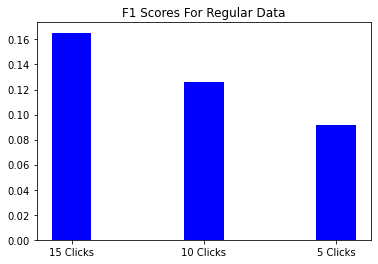

In [56]:
##Plot for not resampled data
import sklearn.metrics

f1_15 = metrics.f1_score(click15_nodown['True Labels'], click15_nodown['Predicted Labels'])
f1_10 = metrics.f1_score(click10_nodown['True Labels'], click10_nodown['Predicted Labels'])
f1_5 = metrics.f1_score(click5_nodown['True Labels'], click5_nodown['Predicted Labels'])
print('F1 scores: ', f1_15, f1_10, f1_5)
w = 0.3
clicks = ['15 Clicks', '10 Clicks', '5 Clicks']
f1s = [f1_15, f1_10, f1_5]
ax = plt.subplot()
ax.bar(clicks, f1s, width=w, color='b', align='center'), plt.title('F1 Scores For Regular Data')
plt.show()

F1 scores:  0.391506303915063 0.38799116997792493 0.36061840843720033


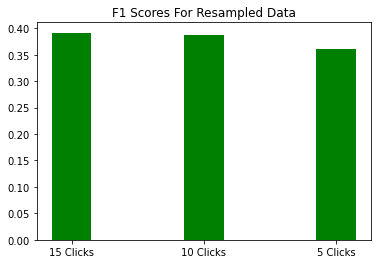

In [57]:
####Plot for Resampled Data
f1_15_2 = metrics.f1_score(click15_down['True Labels'], click15_down['Predicted Labels'])
f1_10_2 = metrics.f1_score(click10_down['True Labels'], click10_down['Predicted Labels'])
f1_5_2 = metrics.f1_score(clicks5_down['True Labels'], clicks5_down['Predicted Labels'])

print('F1 scores: ', f1_15_2, f1_10_2, f1_5_2)
w = 0.3
clicks = ['15 Clicks', '10 Clicks', '5 Clicks']
f1s_2 = [f1_15_2, f1_10_2, f1_5_2]
ax = plt.subplot()
ax.bar(clicks, f1s_2, width=w, color='g', align='center'), plt.title('F1 Scores For Resampled Data')
plt.show()

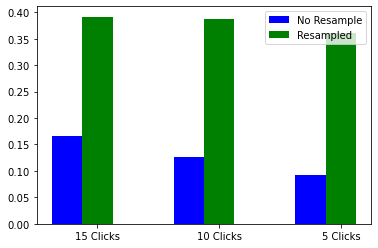

In [58]:
###Plot to compare resampled and regular data
x = np.arange(3)
fig = plt.figure()
ax = plt.subplot()
ax.bar(x, f1s, color = 'b', width = 0.25)
ax.bar(x + 0.25, f1s_2, color = 'g', width = 0.25, tick_label = ['15 Clicks', '10 Clicks', '5 Clicks'])
ax.legend(labels=['No Resample', 'Resampled'])

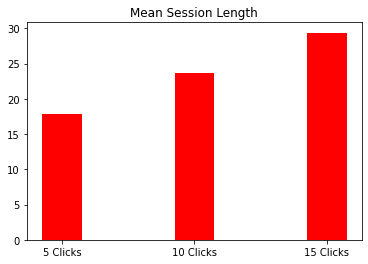

In [59]:
#Mean session length + plot
session_5 = click5_nodown['Session Length'].mean()
session_10 = click10_nodown['Session Length'].mean()
session_15 = click15_nodown['Session Length'].mean()

w = 0.3
sessions = [session_5, session_10, session_15]
clicks = ['5 Clicks', '10 Clicks', '15 Clicks']
ax = plt.subplot()
ax.bar(clicks, sessions, width=w, color='r', align='center'), plt.title('Mean Session Length')
plt.show()

In [78]:
######Return confusion matrix of the specified number of clicks

def xgboost_confusion(n_clicks = '5_clicks', downsample = True):
    
    X_train = train_data[n_clicks]['X']
    y_train = train_data[n_clicks]['Y']
    X_test = test_data[n_clicks]['X']
    y_test = test_data[n_clicks]['Y']
    
    if downsample == True:  ##### If downsample is set to True, this part will run and resample the data
        ### Downsampling the training data
        ### And keep the test data in shape
        temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

        class_0 = temp[temp.purchase == 0]
        class_1 = temp[temp.purchase == 1]

        class_0 = resample(class_0,
                     replace=True,
                     n_samples=len(class_1),
                     random_state=123)


        data_downsampled = pd.concat([class_0, class_1])

        X_train = data_downsampled.session
        y_train = data_downsampled.purchase
    ### Featurization
    ## Doing ngrams with n = 1 AND 2

    one_gram, mapping_1 = encode_sessions(X_train,n=1, mapping=None)
    two_gram, mapping_2 = encode_sessions(X_train,n=2, mapping=None)

    mapping_2 = {key: value + len(mapping_1) for key,value in mapping_2.items()}
    mapping = {**mapping_1, **mapping_2}
    X_train = np.concatenate((one_gram, two_gram), axis=1)

    # featurize X_test
    X = np.zeros((len(X_test), len(mapping)))
    for i, session in enumerate(X_test):
        for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    X_test = X
    
    param_grid = {
        'gamma': [0], 
        'learning_rate': [0.05], 
        'max_depth': [5, 6, 7],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [1]}

    optimal_params = GridSearchCV(
        estimator=XGBClassifier(objective='binary:logistic',
                                    seed=123,
                                    subsample=0.9,
                                    colsample_bytree=0.5),
        param_grid=param_grid,
        scoring='f1',
        verbose = 0,
        n_jobs = 5,
        cv = 3
    )

    optimal_params.fit(X_train,
                      y_train,
                      early_stopping_rounds=10,
                      eval_metric='aucpr',
                      eval_set=[(X_test, y_test)],
                      verbose=False)
    preds = optimal_params.predict(X_test)

    f1 = metrics.f1_score(y_test, preds)
    
    ## Plot the confusion metrics
    plot_confusion_matrix(optimal_params,
                          X_test,
                          y_test,
                          values_format='d')

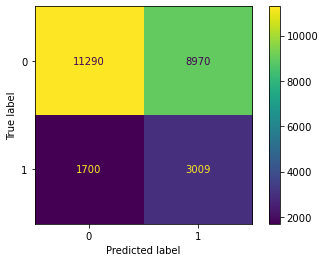

In [79]:
#####5 clicks with downsampling
xgboost_confusion(n_clicks = '5_clicks')

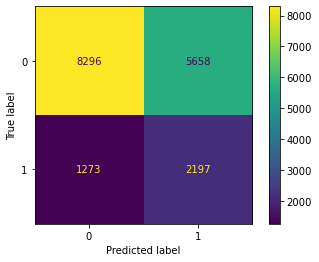

In [80]:
####10 clicks with downsampling
xgboost_confusion('10_clicks')

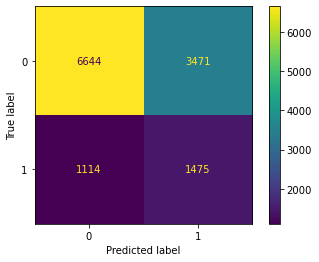

In [81]:
####### 15 clicks with downsampling
xgboost_confusion('15_clicks')

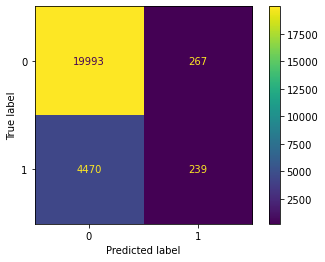

In [82]:
###### 5 clickss no downsampling
xgboost_confusion('5_clicks', False)

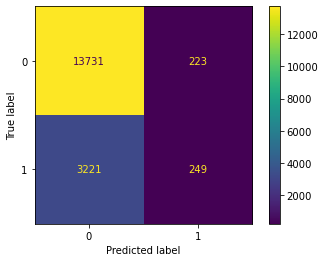

In [83]:
###### 10 clicks no downsampling
xgboost_confusion('10_clicks', False)

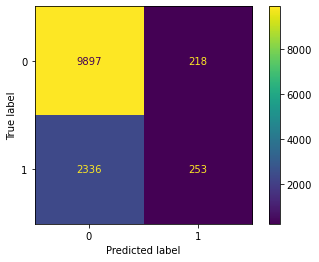

In [84]:
##### 15 clicks no downsampling
xgboost_confusion('15_clicks', False)

In [ ]:
#Save output as a csv
path = os.path.join(wd, "data", "5_clicks_no_downsample.csv")
output_5_clicks.to_csv(path)

In [ ]:
#Save output as a csv
path = os.path.join(wd, "data", "10_clicks_downsampled.csv")
output_10_clicks.to_csv(path)

In [ ]:
#Save output as a csv
path = os.path.join(wd, "data", "15_clicks_downsampled.csv")
output_15_clicks.to_csv(path)

## Error Analysis in R

In [64]:
# pip install rpy2 to be able to run the following cells
%load_ext rpy2.ipython

In [ ]:
%%R
# install the packges if this the first time running R on jupiter
install.packages("plyr", repos='http://cran.us.r-project.org')
install.packages("tidyverse", repos='http://cran.us.r-project.org')
install.packages("effects", repos='http://cran.us.r-project.org')
install.packages("broom", repos='http://cran.us.r-project.org')

In [65]:
%%R

library(plyr)
library(tidyverse)
library(effects)

R[write to console]: -- Attaching packages --------------------------------------- tidyverse 1.3.1 --

R[write to console]: v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

R[write to console]: -- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::arrange()   masks plyr::arrange()
x purrr::compact()   masks plyr::compact()
x dplyr::count()     masks plyr::count()
x dplyr::failwith()  masks plyr::failwith()
x dplyr::filter()    masks stats::filter()
x dplyr::id()        masks plyr::id()
x dplyr::lag()       masks stats::lag()
x dplyr::mutate()    masks plyr::mutate()
x dplyr::rename()    masks plyr::rename()
x dplyr::summarise() masks plyr::summarise()
x dplyr::summarize() masks plyr::summarize()

R[write to console]: Loading required package: carData

R[write to console]: lattice theme set by effectsTheme()
See ?effectsTheme for details.



In [66]:
%%R
print(R.version.string)

[1] "R version 4.1.1 (2021-08-10)"


## Set the correct working directory and import the files

In [86]:
%%R 
# set the correct working directory where the 6 csv files are stored

setwd("C:/Users/Sam/OneDrive/Escritorio/Customer Data/Project Results/")

In [93]:
%%R

X5_clicks_downsampled = read.table("5_clicks_downsampled.csv", header = T, sep=',')
X10_clicks_downsampled = read.table("10_clicks_downsampled.csv", header = T, sep=',')
X15_clicks_downsampled = read.table("15_clicks_downsampled.csv", header = T, sep=',')

X10_clicks_no_downsampled = read.table("10_clicks_no_downsampled.csv", header = T, sep=',')
X15_clicks_no_downsampled = read.table("15_clicks_no_downsampled.csv", header = T, sep=',')
X5_clicks_no_downsampled = read.table("5_clicks_no_downsampled.csv", header = T, sep=',')

In [94]:
%%R

# cleaning and formatting the files
# the 5 clicks buy
X5_clicks_downsampled$X <- NULL
X5_clicks_downsampled$num_of_clicks <- "5_clicks"
colnames(X5_clicks_downsampled)[1] <- "Predicted_Labels"
colnames(X5_clicks_downsampled)[2] <- "True_Labels"
colnames(X5_clicks_downsampled)[3] <- "Accurate"
colnames(X5_clicks_downsampled)[4] <-  "Session_Length"

# the 10 clicks buy
X10_clicks_downsampled$X <- NULL
X10_clicks_downsampled$num_of_clicks <- "10_clicks"
colnames(X10_clicks_downsampled)[1] <- "Predicted_Labels"
colnames(X10_clicks_downsampled)[2] <- "True_Labels"
colnames(X10_clicks_downsampled)[3] <- "Accurate"
colnames(X10_clicks_downsampled)[4] <-  "Session_Length"

# the 15 clicks buy
X15_clicks_downsampled$X <- NULL
X15_clicks_downsampled$num_of_clicks <- "15_clicks"
colnames(X15_clicks_downsampled)[1] <- "Predicted_Labels"
colnames(X15_clicks_downsampled)[2] <- "True_Labels"
colnames(X15_clicks_downsampled)[3] <- "Accurate"
colnames(X15_clicks_downsampled)[4] <-  "Session_Length"


# the 5 clicks no buy
X5_clicks_no_downsampled$X <- NULL
X5_clicks_no_downsampled$num_of_clicks <- "5_clicks"
colnames(X5_clicks_no_downsampled)[1] <- "Predicted_Labels"
colnames(X5_clicks_no_downsampled)[2] <- "True_Labels"
colnames(X5_clicks_no_downsampled)[3] <- "Accurate"
colnames(X5_clicks_no_downsampled)[4] <-  "Session_Length"

# the 10 clicks no buy
X10_clicks_no_downsampled$X <- NULL
X10_clicks_no_downsampled$num_of_clicks <- "10_clicks"
colnames(X10_clicks_no_downsampled)[1] <- "Predicted_Labels"
colnames(X10_clicks_no_downsampled)[2] <- "True_Labels"
colnames(X10_clicks_no_downsampled)[3] <- "Accurate"
colnames(X10_clicks_no_downsampled)[4] <-  "Session_Length"

# the 15 clicks no buy
X15_clicks_no_downsampled$X <- NULL
X15_clicks_no_downsampled$num_of_clicks <- "15_clicks"
colnames(X15_clicks_no_downsampled)[1] <- "Predicted_Labels"
colnames(X15_clicks_no_downsampled)[2] <- "True_Labels"
colnames(X15_clicks_no_downsampled)[3] <- "Accurate"
colnames(X15_clicks_no_downsampled)[4] <-  "Session_Length"


## Combining the data frames

In [95]:
%%R

# combine the 6 data frames to two buy and no_buy data frames
buy <- rbind(X5_clicks_downsampled, X10_clicks_downsampled, X15_clicks_downsampled)
no_buy <- rbind(X5_clicks_no_downsampled, X10_clicks_no_downsampled, X15_clicks_no_downsampled)

head(buy)

  Predicted_Labels True_Labels Accurate Session_Length num_of_clicks
1                0           0        1             28      5_clicks
2                1           0        0             10      5_clicks
3                1           0        0              8      5_clicks
4                1           0        0             15      5_clicks
5                0           0        1             35      5_clicks
6                1           0        0              8      5_clicks


## Fitting the data frames in a logistic regression

In [96]:
%%R

# test the logistic regression on the buy and no_buy data frames
buy_glm.fit <- glm(Accurate ~ True_Labels + Session_Length + num_of_clicks, data = buy, family = binomial)
no_buy_glm.fit <- glm(Accurate ~ True_Labels + Session_Length + num_of_clicks, data = no_buy, family = binomial)

In [97]:
%%R

# summerizing the result for the buy group
summary(buy_glm.fit)


Call:
glm(formula = Accurate ~ True_Labels + Session_Length + num_of_clicks, 
    family = binomial, data = buy)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4924  -1.3108   0.9531   1.0257   1.2317  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.4815147  0.0221118  21.776  < 2e-16 ***
True_Labels             0.1167423  0.0221257   5.276 1.32e-07 ***
Session_Length         -0.0037844  0.0006385  -5.927 3.09e-09 ***
num_of_clicks15_clicks  0.1779631  0.0243949   7.295 2.98e-13 ***
num_of_clicks5_clicks  -0.1429201  0.0204401  -6.992 2.71e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 74280  on 55096  degrees of freedom
Residual deviance: 74059  on 55092  degrees of freedom
AIC: 74069

Number of Fisher Scoring iterations: 4



In [98]:
%%R

# summerizing the result for the on_buy group
summary(no_buy_glm.fit)


Call:
glm(formula = Accurate ~ True_Labels + Session_Length + num_of_clicks, 
    family = binomial, data = no_buy)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9136   0.1742   0.1776   0.1835   2.3360  

Coefficients:
                         Estimate Std. Error  z value Pr(>|z|)    
(Intercept)             4.1280764  0.0717136   57.563   <2e-16 ***
True_Labels            -6.7294890  0.0538107 -125.059   <2e-16 ***
Session_Length          0.0007378  0.0019533    0.378    0.706    
num_of_clicks15_clicks  0.0297892  0.0739896    0.403    0.687    
num_of_clicks5_clicks  -0.0646044  0.0633097   -1.020    0.308    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 54344  on 55096  degrees of freedom
Residual deviance: 12656  on 55092  degrees of freedom
AIC: 12666

Number of Fisher Scoring iterations: 7



## Making the plots

In [99]:
%%R

# create the buy_plot 
buy_glm.fit.effects = as.data.frame(
  Effect(c("True_Labels", "Session_Length", "num_of_clicks"), buy_glm.fit,
         xlevels = list(Session_Length=sort(unique(buy$Session_Length))), 
         confidence.level=.99))

buy_glm.fit.effects$num_of_clicks =factor(buy_glm.fit.effects$num_of_clicks, 
                                      levels = c("5_clicks", "10_clicks", "15_clicks"))


buy_plot <- ggplot(data = buy_glm.fit.effects, aes(Session_Length, fit, color=num_of_clicks, fill=num_of_clicks)) +
                    geom_smooth() +
                    labs(y = 'Accuracy', x = "sequence length") +
                    ggtitle("buy_plot = uracy as a function of length, for diffrent numbers of clicks") +
                    scale_y_continuous(limits = c(0,1)) + 
                    scale_x_continuous(limits = c(5, 160)) +
                    theme(legend.direction = "horizontal", legend.position = "bottom", legend.box = "horizontal", legend.key.height = unit(0.5, "cm"), legend.key.width = unit(1, "cm"))

In [100]:
%%R

# create the no_buy_plot 
no_buy_glm.fit.effects = as.data.frame(
  Effect(c("True_Labels", "Session_Length", "num_of_clicks"), no_buy_glm.fit,
         xlevels = list(Session_Length=sort(unique(no_buy$Session_Length))), 
         confidence.level=.99))

no_buy_glm.fit.effects$num_of_clicks =factor(no_buy_glm.fit.effects$num_of_clicks, 
                                      levels = c("5_clicks", "10_clicks", "15_clicks"))


no_buy_plot <- ggplot(data = no_buy_glm.fit.effects, aes(Session_Length, fit, color=num_of_clicks, fill=num_of_clicks)) +
                    geom_smooth() +
                    labs(y = 'Accuracy', x = "sequence length") +
                    ggtitle("no_buy_plot = Accuracy as a function of length, for diffrent numbers of clicks") +
                    scale_y_continuous(limits = c(0,1)) + 
                    scale_x_continuous(limits = c(5, 160)) +
                    theme(legend.direction = "horizontal", legend.position = "bottom", legend.box = "horizontal", legend.key.height = unit(0.5, "cm"), legend.key.width = unit(1, "cm"))

## Printing the Plots

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



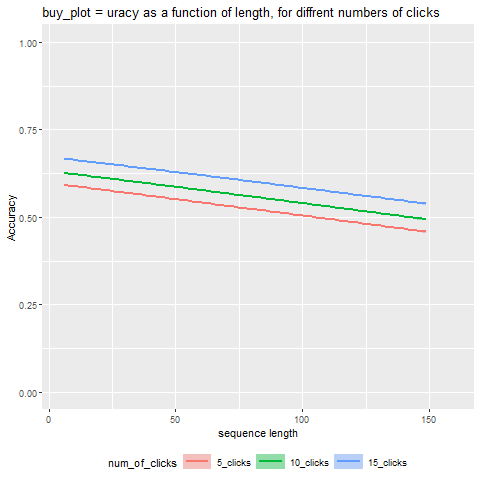

In [101]:
%%R
# print the plot
buy_plot

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



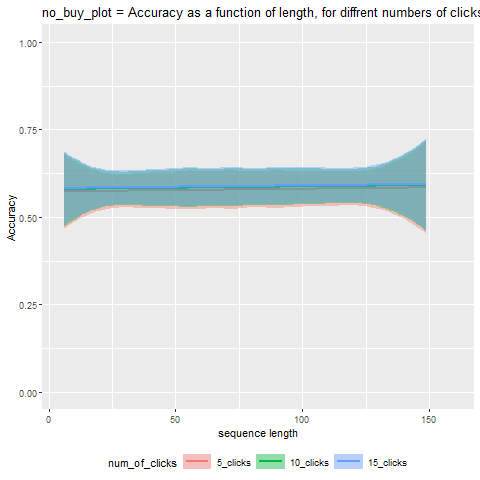

In [102]:
%%R

# print the plot
no_buy_plot